In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import empyrical
from WindPy import w
%matplotlib inline

In [2]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [3]:
def metric(ret):
    an_ret = empyrical.annual_return(ret, period='monthly')
    vol = empyrical.annual_volatility(ret, period='monthly')
    maxdraw = empyrical.max_drawdown(ret)
    print('Annual return: %.2f%%'%(an_ret*100))
    print('Sharpe ratio: %.2f'%(an_ret / vol))
    print('Annual volatility: %.2f%%'%(vol*100))
    print('Max drawdown: %.2f%%'%(maxdraw*100))

# 读取数据

In [4]:
wind = pd.read_excel('../data/wind.xlsx', index_col=0)

In [5]:
wind.tail()

,Wind Index,Wind Index PE
881001.WI,,
2019-12-31,4316.4899,17.497700
2020-01-31,4305.5828,17.383600
2020-02-28,4304.3983,17.082199
2020-03-31,4023.3092,15.893500
2020-04-30,4233.8174,18.361401


In [6]:
df = pd.read_excel(u'../data/global strategy data.xlsx', sheet_name='data', index_col=0)

In [7]:
df.tail()

,SHCOMP Index,HSI Index,SPXT Index,LUATTRUU Index,CNDR1Y index,SHCOMP Index PE,HSI Index PE,SPX Index PE,FDTRMID Index
1997-12-31 00:00:00,,,,,,,,,
2019-12-31,635.6997,51340.4090,45635.12934,2369.779,1.5,14.2893,11.2475,21.2084,1.625
2020-01-31,625.4447,47705.5663,45273.30590,2427.692,1.5,13.9488,10.4985,21.1465,1.625
2020-02-28,597.8421,47770.4366,42034.61733,2492.039,1.5,13.6062,10.4256,19.4044,1.625
2020-03-31,563.5870,44015.5823,37318.05516,2564.117,1.5,14.0742,9.8092,17.6500,0.125
2020-04-30,587.7222,45935.4585,41989.05824,2580.425,1.5,14.6457,10.2414,19.8478,0.125


In [8]:
df = df.merge(wind, left_index=True, right_index=True)

In [9]:
a_stock, hk_stock, us_stock = 'Wind Index', 'HSI Index', 'SPXT  Index'
asset_columns = [a_stock, hk_stock, us_stock, 'LUATTRUU Index']

In [10]:
assets_ret = df[asset_columns].pct_change()

In [11]:
fed_rate = df['FDTRMID Index']

In [12]:
assets_ret.tail()

,Wind Index,HSI Index,SPXT Index,LUATTRUU Index
2019-12-31,0.059259,0.044291,0.056157,-0.008604
2020-01-31,-0.002527,-0.070799,-0.007929,0.024438
2020-02-28,-0.000275,0.001360,-0.071536,0.026505
2020-03-31,-0.065303,-0.078602,-0.112207,0.028923
2020-04-30,0.052322,0.043618,0.125167,0.006360


# 计算估值偏离

In [13]:
pe = df[['Wind Index PE', 'HSI Index PE', 'SPX Index PE']]

In [14]:
pe_dev = (pe - pe.rolling(60).mean()) / pe.rolling(60).mean()

In [15]:
pe_dev = pe_dev.dropna()

# 回测

In [16]:
# 判断当前状态
def regime_weight(date):
    rate_change = fed_rate[fed_rate.index <= date].diff(3).iloc[-1]
    if rate_change == 0:
        return np.array([0.3, 0.3, 0.3, 0.1])
    elif rate_change > 0:
        return np.array([1./3, 1./3, 1./3, 0.])
    else:
        return np.array([0.8/3, 0.8/3, 0.8/3, 0.2])

In [17]:
def weight_change(w, dev):
    if dev < -0.3:
        return w + 0.35
    elif -0.3 <= dev and dev < -0.2:
        return w + 0.25
    elif -0.2 <= dev and dev < -0.1:
        return w + 0.15
    elif 0.1 <= dev and dev < 0.2:
        return max(0, w - 0.15)
    elif 0.2 <= dev and dev < 0.3:
        return max(0, w - 0.25)
    elif dev >= 0.3:
        return max(0, w - 0.35)
    else:
        return w

In [18]:
def calc_weight(date):
#     print(date)
    w = regime_weight(date)
    current_pe_dev = pe_dev[pe_dev.index <= date].loc[date]
    
#     print(w)
    
    init_w = w[:3].sum()
    w[0] = weight_change(w[0], current_pe_dev['Wind Index PE'])
    w[1] = weight_change(w[1], current_pe_dev['HSI Index PE'])
    w[2] = weight_change(w[2], current_pe_dev['SPX Index PE'])
    
#     print(w)

    sum_w = w[:3].sum()
    w[0] = w[0] * init_w / sum_w
    w[1] = w[1] * init_w / sum_w
    w[2] = w[2] * init_w / sum_w
    
#     print(w)

    return w

In [19]:
assets_ret = assets_ret[assets_ret.index >= '2005-01-01']

In [20]:
weight = pd.DataFrame(columns=assets_ret.columns, index=assets_ret.index)
n = assets_ret.shape[1]
wb = np.zeros(n)

for date in weight.index:
    wb = calc_weight(date)
    weight.loc[date] = wb

In [21]:
portfolio = (weight.shift(1) * assets_ret).sum(axis=1)

In [22]:
portfolio.tail()

2019-12-31    0.041629
2020-01-31   -0.016780
2020-02-28   -0.013486
2020-03-31   -0.071361
2020-04-30    0.060234
dtype: float64

In [23]:
metric(portfolio)

Annual return: 10.32%
Sharpe ratio: 0.68
Annual volatility: 15.22%
Max drawdown: -49.40%


# 业绩对比

In [24]:
data = w.wsd('000001.SH, CBA00101.CS, HSI.HI,SPX.GI', 'pct_chg', assets_ret.index[0], assets_ret.index[-1], 'Period=M')

In [25]:
bdf = pd.DataFrame(np.array(data.Data).T/100, index=data.Times, columns=data.Codes)

In [26]:
bdf.iloc[0] = 0

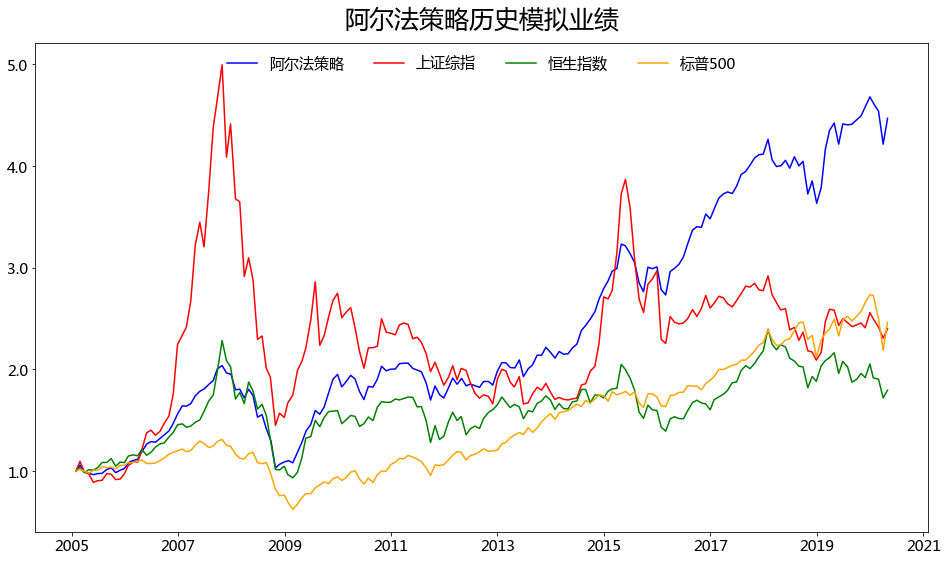

In [27]:
fig, ax = plt.subplots(figsize=(16, 9))

lns1 = ax.plot((1 + portfolio).cumprod(), color='blue', label=u'阿尔法策略')
lns2 = ax.plot((1 + bdf['000001.SH']).cumprod(), color='red', label=u'上证综指')
lns3 = ax.plot((1 + bdf['HSI.HI']).cumprod(), color='green', label=u'恒生指数')
lns4 = ax.plot((1 + bdf['SPX.GI']).cumprod(), color='orange', label=u'标普500')

lns = lns1 + lns2 + lns3 + lns4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, frameon=False, fontsize=15, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.0))

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.1f}'.format(x) for x in vals])

_ = ax.set_title(u'阿尔法策略历史模拟业绩', fontsize=25, y=1.02)

In [28]:
weight = weight.astype(np.float32)

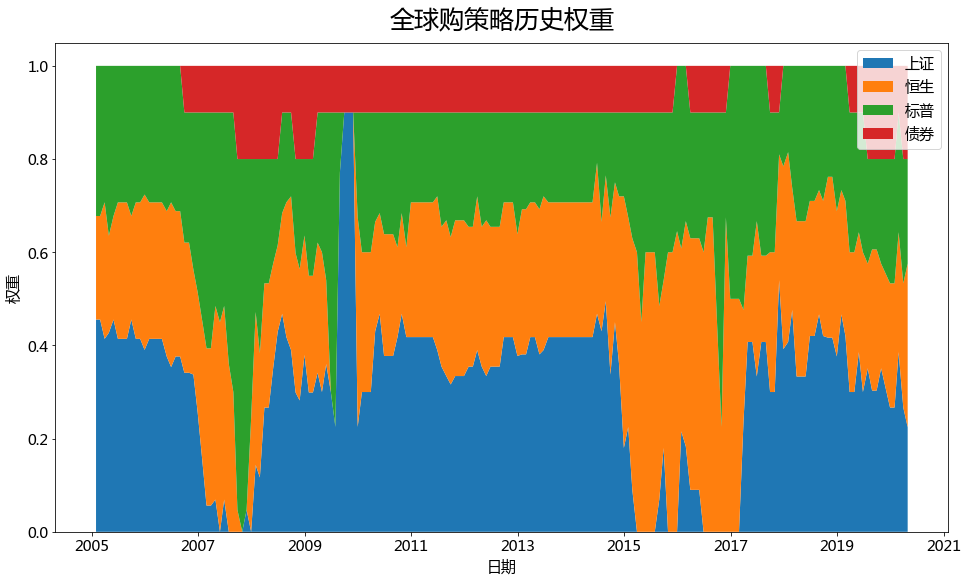

In [29]:
fig, ax = plt.subplots(figsize=(16, 9))
_ = ax.stackplot(weight.index, 
                 weight['Wind Index'],
                 weight['HSI Index'],
                 weight['SPXT  Index'],
                 weight['LUATTRUU Index'],
                 labels=[u'上证', u'恒生', u'标普', u'债券'])
ax.legend(fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_ylabel(u'权重', fontsize=15)
ax.set_xlabel(u'日期', fontsize=15)
_ = ax.set_title(u'全球购策略历史权重', fontsize=25, y=1.02)

In [30]:
weight.tail()

,Wind Index,HSI Index,SPXT Index,LUATTRUU Index
2019-12-31,0.266667,0.266667,0.266667,0.2
2020-01-31,0.266667,0.266667,0.266667,0.2
2020-02-28,0.385714,0.257143,0.257143,0.1
2020-03-31,0.266667,0.266667,0.266667,0.2
2020-04-30,0.224561,0.350877,0.224561,0.2


In [31]:
weight.to_excel('../data/weight.xlsx')